In [1]:
import warnings
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import lsst.afw.geom as afw_geom
import lsst.afw.table as afw_table
import lsst.daf.persistence as dp
import GCRCatalogs
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    from lsst.sims.utils import rotationMatrixFromVectors
    from lsst.sims.utils import cartesianFromSpherical, sphericalFromCartesian

In [2]:
class FieldRotator(object):

    def __init__(self, ra0, dec0, ra1, dec1):
        """
        Parameters
        ----------
        ra0, dec0 are the coordinates of the original field
        center in degrees
        ra1, dec1 are the coordinates of the new field center
        in degrees
        The transform() method of this class operates by first
        applying a rotation that carries the original field center
        into the new field center.  Points are then transformed into
        a basis in which the unit vector defining the new field center
        is the x-axis.  A rotation about the x-axis is applied so that
        a point that was due north of the original field center is still
        due north of the field center at the new location.  Finally,
        points are transformed back into the original x,y,z bases.
        """

        # find the rotation that carries the original field center
        # to the new field center
        xyz = cartesianFromSpherical(np.radians(ra0), np.radians(dec0))
        xyz1 = cartesianFromSpherical(np.radians(ra1), np.radians(dec1))
        if np.abs(1.0-np.dot(xyz, xyz1))<1.0e-10:
            self._transformation = np.identity(3, dtype=float)
            return

        first_rotation = rotationMatrixFromVectors(xyz, xyz1)

        # create a basis set in which the unit vector
        # defining the new field center is the x axis
        xx = np.dot(first_rotation, xyz)
        rng = np.random.RandomState(99)
        mag = np.NaN
        while np.abs(mag)<1.0e-20 or np.isnan(mag):
            random_vec = rng.random_sample(3)
            comp = np.dot(random_vec, xx)
            yy = random_vec - comp*xx
            mag = np.sqrt((yy**2).sum())
            yy /= mag

        zz = np.cross(xx, yy)

        to_self_bases = np.array([xx,
                                  yy,
                                  zz])

        out_of_self_bases =to_self_bases.transpose()

        # Take a point due north of the original field
        # center.  Apply first_rotation to carry it to
        # the new field.  Transform it to the [xx, yy, zz]
        # bases and find the rotation about xx that will
        # make it due north of the new field center.
        # Finally, transform back to the original bases.
        d_dec = 0.1
        north = cartesianFromSpherical(np.radians(ra0),
                                       np.radians(dec0+d_dec))

        north = np.dot(first_rotation, north)

        #print(np.degrees(sphericalFromCartesian(north)))

        north_true = cartesianFromSpherical(np.radians(ra1),
                                            np.radians(dec1+d_dec))

        north = np.dot(to_self_bases, north)
        north_true = np.dot(to_self_bases, north_true)
        north = np.array([north[1], north[2]])
        north /= np.sqrt((north**2).sum())
        north_true = np.array([north_true[1], north_true[2]])
        north_true /= np.sqrt((north_true**2).sum())

        c = north_true[0]*north[0]+north_true[1]*north[1]
        s = north[0]*north_true[1]-north[1]*north_true[0]
        norm = np.sqrt(c*c+s*s)
        c = c/norm
        s = s/norm

        nprime = np.array([c*north[0]-s*north[1],
                           s*north[0]+c*north[1]])

        yz_rotation = np.array([[1.0, 0.0, 0.0],
                                [0.0, c, -s],
                                [0.0, s, c]])

        second_rotation = np.dot(out_of_self_bases,
                                 np.dot(yz_rotation,
                                        to_self_bases))

        self._transformation = np.dot(second_rotation,
                                      first_rotation)

    def transform(self, ra, dec):
        """
        ra, dec are in degrees; return the RA, Dec coordinates
        of the point about the new field center
        """
        xyz = cartesianFromSpherical(np.radians(ra), np.radians(dec)).transpose()
        xyz = np.dot(self._transformation, xyz).transpose()
        ra_out, dec_out = sphericalFromCartesian(xyz)
        return np.degrees(ra_out), np.degrees(dec_out)


In [3]:
def mag_cols(bands):
    Coldef = namedtuple('Coldef', 'name type doc'.split())
    return [Coldef('mag_{}'.format(x), float, '{}-magnitude'.format(x))
            for x in bands]

def make_SourceCatalog(new_cols):
    """Make a minimal SourceCatalog to contain positions, etc."""
    schema = afw_table.SourceTable.makeMinimalSchema()
    for coldef in new_cols:
        schema.addField(coldef.name, type=coldef.type, doc=coldef.doc)
    return afw_table.SourceCatalog(schema)

class PatchSelector:
    protoDC2_ra = 55.064
    protoDC2_dec = -29.783
    field_rotator = FieldRotator(0, 0, protoDC2_ra, protoDC2_dec)
    def __init__(self, butler, tract, patch_index):
        # Get the patch boundaries.
        skymap = butler.get('deepCoadd_skyMap')
        tractInfo = skymap[tract]
        wcs = tractInfo.getWcs()
        patchInfo = tractInfo.getPatchInfo(patch_index)
        patchBox = afw_geom.Box2D(patchInfo.getOuterBBox())
        patch_corners = patchBox.getCorners()
        ra_values, dec_values = [], []
        for corner in patch_corners:
            ra, dec = wcs.pixelToSky(corner)
            ra_values.append(ra.asDegrees())
            dec_values.append(dec.asDegrees())
        self.ra_range = min(ra_values), max(ra_values)
        self.dec_range = min(dec_values), max(dec_values)

    def __call__(self, gc, band, max_mag):
        # Retrieve the desired columns and filter on magnitude values.
        bandname = 'mag_true_{}_lsst'.format(band)
        filter_ = '{} < {}'.format(bandname, max_mag)
        print("Applying magnitude filter:", filter_)
        gc_cols = gc.get_quantities(['galaxy_id', 'ra_true', 'dec_true',
                                     bandname], filters=[filter_])
        print("Number of galaxies passing magnitude filter:", len(gc_cols[bandname]))
        # Rotate to the Run1.1p field.
        gc_ra_rot, gc_dec_rot \
            = self.field_rotator.transform(gc_cols['ra_true'],
                                           gc_cols['dec_true'])

        # Select the galaxies within the patch.
        index = np.where((gc_ra_rot > self.ra_range[0]) &
                         (gc_ra_rot < self.ra_range[1]) &
                         (gc_dec_rot > self.dec_range[0]) &
                         (gc_dec_rot < self.dec_range[1]))
        galaxy_id = gc_cols['galaxy_id'][index]
        gc_ra = gc_ra_rot[index]
        gc_dec = gc_dec_rot[index]
        gc_mag = gc_cols[bandname][index]
        print("Number of galaxies within patch:", len(galaxy_id))

        # Create a SourceCatalog with the galaxy_ids, coordinates, magnitudes
        galaxy_catalog = make_SourceCatalog(mag_cols((band,)))
        for id_, ra, dec, mag in zip(galaxy_id, gc_ra, gc_dec, gc_mag):
            record = galaxy_catalog.addNew()
            record.set('id', id_)
            record.set('coord_ra', afw_geom.Angle(ra, afw_geom.degrees))
            record.set('coord_dec', afw_geom.Angle(dec, afw_geom.degrees))
            record.set('mag_{}'.format(band), mag)
        return galaxy_catalog

In [4]:
# Create a data butler for the repo.
repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output'
butler = dp.Butler(repo)

# Pick filter, tract, and patch.
filter_ = 'r'
mag_max = 24.5
#tract = 4850
#tract = 5063
tract = 4638
patch_index = 2, 2

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
# Get the DRP catalog for a selected tract and patch
patch_id = '{},{}'.format(*patch_index)
dataId = dict(tract=tract, patch=patch_id, filter=filter_)
coadd_catalog = butler.get('deepCoadd_meas', dataId=dataId)
coadd_calexp = butler.get('deepCoadd', dataId=dataId)
calib = coadd_calexp.getCalib()

# Select primary DRP galaxies with mag < mag_max.
ext = coadd_catalog.get('base_ClassificationExtendedness_value')
model_flag = coadd_catalog.get('modelfit_CModel_flag')
model_flux = coadd_catalog.get('modelfit_CModel_flux')
num_children = coadd_catalog.get('deblend_nChild')
cat_temp = coadd_catalog.subset((ext == 1) &
                                (model_flag == False) &
                                (model_flux > 0) &
                                (num_children == 0))
mag = calib.getMagnitude(cat_temp['modelfit_CModel_flux'])
cat_temp = cat_temp.subset(mag < mag_max)

drp_catalog = make_SourceCatalog(mag_cols((filter_,)))
for record in cat_temp:
    new_rec = drp_catalog.addNew()
    for name in 'id coord_ra coord_dec parent'.split():
        new_rec.set(name, record[name])
    new_rec.set('mag_{}'.format(filter_),
                calib.getMagnitude(record['modelfit_CModel_flux']))
print("Number of extended objects in DRP catalog", len(drp_catalog))

Number of extended objects in DRP catalog 2584


In [6]:
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('proto-dc2_v2.1.2_test')

# Create function to down-select galaxy catalog entries to lie within
# a tract/patch.
patch_selector = PatchSelector(butler, tract, patch_index)

# Create a SourceCatalog from the gc data, restricting to the
# tract/patch being considered.
galaxy_catalog = patch_selector(gc, band=filter_, max_mag=mag_max)

Applying magnitude filter: mag_true_r_lsst < 24.5
Number of galaxies passing magnitude filter: 1971026
Number of galaxies within patch: 2684


In [7]:
# Find positional matches within 100 milliarcseconds.
radius = afw_geom.Angle(0.1, afw_geom.arcseconds)
matches = afw_table.matchRaDec(drp_catalog, galaxy_catalog, radius)

# Compare magnitudes for matched objects.
drp_mag = np.zeros(len(matches), dtype=np.float)
gc_mag = np.zeros(len(matches), dtype=np.float)
sep = np.zeros(len(matches), dtype=np.float)
# Arrays for a quiver plot.
u = np.zeros(len(matches), dtype=np.float)
v = np.zeros(len(matches), dtype=np.float)
for i, match in enumerate(matches):
    drp_mag[i] = match.first['mag_{}'.format(filter_)]
    gc_mag[i] = match.second['mag_{}'.format(filter_)]
    sep[i] = np.degrees(match.distance)*3600.*1000.
    u[i] = match.first['coord_ra'] - match.second['coord_ra']
    v[i] = match.first['coord_dec'] - match.second['coord_dec']
print("Number of matches:", len(matches))

Number of matches: 1449


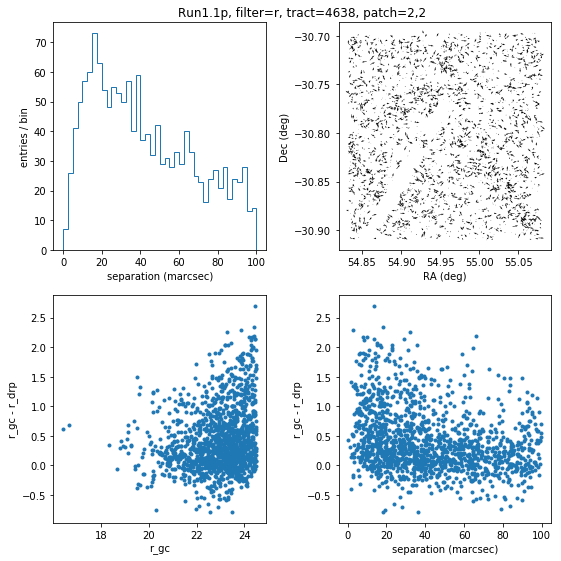

In [8]:
title = 'Run1.1p, filter={}, tract={}, patch={}'.format(filter_, tract, patch_id)

plt.rcParams['figure.figsize'] = 8, 8
fig = plt.figure()
frame_axes = fig.add_subplot(111, frameon=False)
frame_axes.set_title(title)
frame_axes.get_xaxis().set_ticks([])
frame_axes.get_yaxis().set_ticks([])

# Histogram of match separations.
fig.add_subplot(2, 2, 1)
plt.hist(sep, range=(0, 100), histtype='step', bins=40)
plt.xlabel('separation (marcsec)')
plt.ylabel('entries / bin')

# Quiver plot of (DRP - galaxy_catalog) positions on the sky.
fig.add_subplot(2, 2, 2)
plt.quiver(np.degrees(drp_catalog['coord_ra']),
           np.degrees(drp_catalog['coord_dec']),
           u, v)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

# Difference in magnitudes vs mag_gc.
fig.add_subplot(2, 2, 3)
plt.errorbar(gc_mag, gc_mag - drp_mag, fmt='.')
plt.xlabel('{}_gc'.format(filter_))
plt.ylabel('{0}_gc - {0}_drp'.format(filter_))

# Difference in magnitudes vs separation.
fig.add_subplot(2, 2, 4)
plt.errorbar(sep, gc_mag - drp_mag, fmt='.')
plt.xlabel('separation (marcsec)')
plt.ylabel('{0}_gc - {0}_drp'.format(filter_))

plt.tight_layout()